<h1>Problem Definition & Objectives</h1>

<h2>Objectives</h2>
<ul>
    <li>Build a trading algorithm using the SSL Indicator combined with a volume and momentum indicator</li>
    <li>Backtest the strategy on historical stock data and compare its performance with the S&P 500</li>
</ul>
<h2>Key Goals</h2>
<ul>
    <li>Develop a trading startegy that balances return and risk.</li>
    <li>Ensure the startegy is scalable, modular, and adheres to industry standards.</li>
</ul>

<h1>Optimal RSI Buy and RSI sell threshholds</h1>
<p>Maximizing the Sharpe Ratio or Cumulative Returns</p>
<h4>Hypothesis:</h4>
<p>Instead of using fixed levels ( RSI 30 for buy and RSI 70 for sell), aim to optimize these threshholds to improve the strategy's performance over historical data.</p>

In [1]:
from IPython.display import display, Javascript
display(Javascript("IPython.notebook.kernel.restart()"))

<IPython.core.display.Javascript object>

In [3]:
# Back Testing 
# Sharpe Ratio
# Maximum Drawdown
# Cumulative Return

import backtrader as bt
import yfinance as yf

class Backtest:
    """
    A class to handle backtesting using Backtrader.
    
    Attributes:
        strategy (bt.Strategy): The strategy class to be tested.
        data (pd.DataFrame): The historical data to be used for backtesting.
        cash (float): The initial capital.
        commission (float): The commission per trade.

    Methods:
        run_backtest(): Sets up the backtest and returns the cerebro engine for further analysis or plotting.
        plot_results(): Plots the results of the backtest using BackTrader's built in plot functionality.
        
    """
    
    def __init__(self, strategy, data, cash=10000, commission=0.001):
        """
        Initialize the Backtest class with strategy, data, cash, and commission.
        
        Parameters:
            strategy (bt.Strategy): A Backtrader strategy class.
            data (pd.DataFrame): Historical market data for backtesting.
            cash (float): Initial cash for backtesting. Default is 10,000.
            commission (float): Commission per trade. Default is 0.1%.
        """
        self.strategy = strategy
        self.data = data
        self.cash = cash
        self.commission = commission

    def run_backtest(self, **kwargs):
        """
        Execute the backtest with the provided strategy and data.

        Parameters: 
            **kwargs: Arguments to override the strategy parameters.
        
        Returns:
            cerebro: The Backtrader engine instance with the run results.
        """
        cerebro = bt.Cerebro()

        # Add the strategy to Cerebro
        cerebro.addstrategy(self.strategy)

        # Convert the DataFrame to Backtrader Data Feed
        data_feed = bt.feeds.PandasData(dataname=self.data)
        cerebro.adddata(data_feed)

        # Set initial cash
        cerebro.broker.setcash(self.cash)

        # Set commission
        cerebro.broker.setcommission(commission=self.commission)

        # Run the backtest
        results = cerebro.run()

        # Return the engine instance for further analysis or plotting
        return cerebro, results

    def plot_results(self, cerebro):
        """
        Plot the results of the backtest.
        
        Parameters:
            cerebro: The Backtrader engine instance with the run results.
        """
        cerebro.plot(style='candlestick')

class RSI_Strategy(bt.Strategy):
    """
    A simple RSI-based trading strategy.
    
    Attributes:
        rsi_period (int): The period for calculating RSI.
        rsi_buy (int): The RSI threshold for buying.
        rsi_sell (int): The RSI threshold for selling.

    Methods:
        next(): This method is called for every time step (data point).
    """
    
    params = (
        ('rsi_period', 14),  # Default RSI period
        ('rsi_buy', 30),     # Default RSI buy threshold
        ('rsi_sell', 70),    # Default RSI sell threshold
    )

    def __init__(self):
        """
        Initialize the strategy and indicators.
        """
        self.rsi = bt.indicators.RelativeStrengthIndex(self.data.close, period=self.params.rsi_period)

    def next(self):
        """
        This method is called on every time step (new data point) to evaluate
        the trading logic.
        """
        # Check if there are no open positions
        if not self.position:
            # Buy condition: RSI below the buy threshold
            if self.rsi < self.params.rsi_buy:
                self.buy()
        
        # Check if there is an open position
        else:
            # Sell condition: RSI above the sell threshold
            if self.rsi > self.params.rsi_sell:
                self.sell()

class SSL_RSI_Strategy(bt.Strategy):
    params = (
        ('ssl_period', 10),  # Period for the moving averages used in SSL
        ('rsi_period', 14),  # RSI period
        ('rsi_buy', 30),     # RSI level to buy
        ('rsi_sell', 70),    # RSI level to sell
    )

    def __init__(self):
        # SSL Semaphore Signal: Moving Average crossovers
        self.sma_high = bt.indicators.SimpleMovingAverage(self.data.high, period=self.params.ssl_period)
        self.sma_low = bt.indicators.SimpleMovingAverage(self.data.low, period=self.params.ssl_period)

        # RSI Indicator
        self.rsi = bt.indicators.RelativeStrengthIndex(self.data.close, period=self.params.rsi_period)

    def next(self):
        # Generate SSL-based buy and sell signals
        if not self.position:  # No open positions
            # Buy condition: price above SSL and RSI confirms oversold
            if self.data.close > self.sma_high and self.rsi < self.params.rsi_buy:
                self.buy()
        
        elif self.position:
            # Sell condition: price below SSL and RSI confirms overbought
            if self.data.close < self.sma_low and self.rsi > self.params.rsi_sell:
                self.sell()
    

def fetch_data(ticker, start_date, end_date):
    """
    Fetch historical data using Yahoo Finance.
    
    Parameters:
        ticker (str): The stock ticker symbol (e.g., 'AAPL').
        start_date (str): The start date for the data in 'YYYY-MM-DD' format.
        end_date (str): The end date for the data in 'YYYY-MM-DD' format.
    
    Returns:
        pd.DataFrame: The historical data.
    """
    return yf.download(ticker, start=start_date, end=end_date)

def run_rsi_backtest(ticker, rsi_buy=30, rsi_sell=70, rsi_period=21):
    """
    Run a backtest on the specified ticker with the given RSI thresholds.
    
    Parameters:
        ticker (str): The stock ticker symbol (e.g., 'AAPL').
        rsi_buy (int): The RSI level below which to buy.
        rsi_sell (int): The RSI level above which to sell.
    
    Returns:
        cerebro: The Backtrader engine instance with the run results.
    """
    # Fetch historical data
    data = fetch_data(ticker, '2010-01-01', '2024-09-09')

    # Define the RSI strategy with the chosen buy and sell levels
    strategy = RSI_Strategy
    
    # Create the backtest with the chosen strategy and data
    backtest = Backtest(strategy, data)

    # Run the backtest
    cerebro, results = backtest.run_backtest(rsi_buy=rsi_buy, rsi_sell=rsi_sell, rsi_period=rsi_period)

    # Get the initial and final portfolio values directly from Backtrader
    initial_value = backtest.cash  # Initial value is the cash we started with
    final_value = cerebro.broker.getvalue()  # Final portfolio value after the backtest

    # Calculate cumulative return
    cumulative_return = (final_value - initial_value) / initial_value * 100  # In percentage

    # Calculate Sharpe Ratio (you can refine this calculation)
    sharpe_ratio = (final_value - initial_value) / (data['Close'].std() * len(data) ** 0.5)  # Simple Sharpe Ratio

    # Maximum Drawdown
    # Extract portfolio values for maximum drawdown calculation
    portfolio_values = [x.broker.getvalue() for x in results]

    # Compute maximum drawdown
    if portfolio_values:  # Ensure portfolio_values is not empty
        max_drawdown = (1 - min(portfolio_values) / max(portfolio_values)) * 100  # In percentage
    else:
        max_drawdown = 0  # No data, set drawdown to 0


    # Plot the results
    backtest.plot_results(cerebro)

    return {
        'cumulative_return': cumulative_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'final_value': final_value
    }

def run_ssl_rsi_backtest(ticker, ssl_period=10, rsi_period=14, rsi_buy=30, rsi_sell=70):
    """
    Run a backtest on the specified ticker using both SSL and RSI strategies.
    
    Parameters:
        ticker (str): The stock ticker symbol (e.g., 'AAPL').
        ssl_period (int): The period for the SSL Semaphore Signal (moving averages).
        rsi_period (int): The period for calculating the RSI indicator.
        rsi_buy (int): The RSI level below which to buy.
        rsi_sell (int): The RSI level above which to sell.
    
    Returns:
        dict: A dictionary containing performance metrics (cumulative return, Sharpe ratio, final value).
    """
    # Fetch historical data
    data = fetch_data(ticker, '2010-01-01', '2024-09-09')

    # Define the combined SSL and RSI strategy with the chosen parameters
    strategy = SSL_RSI_Strategy

    # Create the backtest with the chosen strategy and data
    backtest = Backtest(strategy, data)

    # Run the backtest
    cerebro, results = backtest.run_backtest(ssl_period=ssl_period, rsi_period=rsi_period, rsi_buy=rsi_buy, rsi_sell=rsi_sell)

    # Get the initial and final portfolio values directly from Backtrader
    initial_value = backtest.cash  # Initial value is the cash we started with
    final_value = cerebro.broker.getvalue()  # Final portfolio value after the backtest

    # Calculate cumulative return
    cumulative_return = (final_value - initial_value) / initial_value * 100  # In percentage

    # Calculate Sharpe Ratio (you can refine this calculation)
    sharpe_ratio = (final_value - initial_value) / (data['Close'].std() * len(data) ** 0.5)  # Simple Sharpe Ratio

    # Maximum Drawdown
    # Extract portfolio values for maximum drawdown calculation
    portfolio_values = [x.broker.getvalue() for x in results]

    # Compute maximum drawdown
    if portfolio_values:  # Ensure portfolio_values is not empty
        max_drawdown = (1 - min(portfolio_values) / max(portfolio_values)) * 100  # In percentage
    else:
        max_drawdown = 0  # No data, set drawdown to 0

    # Plot the results
    backtest.plot_results(cerebro)

    return {
        'cumulative_return': cumulative_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'final_value': final_value
    }



<h2>Grid Search</h2>

In [4]:
# RSI levels as hyperparameters that need to be optimized, similar to how hyperparameters are tuned. 
# Grid Search 

import itertools

# Define the range of RSI buy and sell levels to test
rsi_buy_levels = range(10, 50, 5)  # Buy if RSI < level (e.g., 10, 15, 20, ..., 45)
rsi_sell_levels = range(50, 90, 5)  # Sell if RSI > level (e.g., 50, 55, 60, ..., 85)

results = [] 

# Iterate over all combinations of RSI levels
for buy_level, sell_level in itertools.product(rsi_buy_levels, rsi_sell_levels):
    print(f"Testing Buy RSI: {buy_level}, Sell RSI: {sell_level}")
    performance = run_rsi_backtest('NVDA', rsi_buy=buy_level, rsi_sell=sell_level)

    # Store the performance metrics
    results.append({'buy_level': buy_level, 
                    'sell_level': sell_level, 
                    'performance': performance,
                    'cumulative_return': performance['cumulative_return'],
                    'sharpe_ratio': performance['sharpe_ratio'],
                    'final_value': performance['final_value']})

# Print the results
for result in results:
    print(result)

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 10, Sell RSI: 50


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 10, Sell RSI: 55


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 10, Sell RSI: 60


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 10, Sell RSI: 65


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 10, Sell RSI: 70


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 10, Sell RSI: 75


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 10, Sell RSI: 80


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 10, Sell RSI: 85


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 15, Sell RSI: 50


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 15, Sell RSI: 55


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 15, Sell RSI: 60


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 15, Sell RSI: 65


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 15, Sell RSI: 70


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 15, Sell RSI: 75


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 15, Sell RSI: 80


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 15, Sell RSI: 85


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 20, Sell RSI: 50


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 20, Sell RSI: 55


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 20, Sell RSI: 60


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 20, Sell RSI: 65


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 20, Sell RSI: 70


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 20, Sell RSI: 75


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 20, Sell RSI: 80


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 20, Sell RSI: 85


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 25, Sell RSI: 50


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 25, Sell RSI: 55


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 25, Sell RSI: 60


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 25, Sell RSI: 65


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 25, Sell RSI: 70


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 25, Sell RSI: 75


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 25, Sell RSI: 80


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 25, Sell RSI: 85


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 30, Sell RSI: 50


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 30, Sell RSI: 55


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 30, Sell RSI: 60


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 30, Sell RSI: 65


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 30, Sell RSI: 70


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 30, Sell RSI: 75


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 30, Sell RSI: 80


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 30, Sell RSI: 85


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 35, Sell RSI: 50


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 35, Sell RSI: 55


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 35, Sell RSI: 60


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 35, Sell RSI: 65


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 35, Sell RSI: 70


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 35, Sell RSI: 75


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 35, Sell RSI: 80


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 35, Sell RSI: 85


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 40, Sell RSI: 50


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 40, Sell RSI: 55


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 40, Sell RSI: 60


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 40, Sell RSI: 65


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 40, Sell RSI: 70


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 40, Sell RSI: 75


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 40, Sell RSI: 80


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 40, Sell RSI: 85


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 45, Sell RSI: 50


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 45, Sell RSI: 55


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 45, Sell RSI: 60


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 45, Sell RSI: 65


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 45, Sell RSI: 70


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 45, Sell RSI: 75


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 45, Sell RSI: 80


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Testing Buy RSI: 45, Sell RSI: 85


<IPython.core.display.Javascript object>

{'buy_level': 10, 'sell_level': 50, 'performance': {'cumulative_return': -0.07079527592033628, 'sharpe_ratio': -0.005281235034089789, 'final_value': 9992.920472407966}, 'cumulative_return': -0.07079527592033628, 'sharpe_ratio': -0.005281235034089789, 'final_value': 9992.920472407966}
{'buy_level': 10, 'sell_level': 55, 'performance': {'cumulative_return': -0.07079527592033628, 'sharpe_ratio': -0.005281235034089789, 'final_value': 9992.920472407966}, 'cumulative_return': -0.07079527592033628, 'sharpe_ratio': -0.005281235034089789, 'final_value': 9992.920472407966}
{'buy_level': 10, 'sell_level': 60, 'performance': {'cumulative_return': -0.07079527592033628, 'sharpe_ratio': -0.005281235034089789, 'final_value': 9992.920472407966}, 'cumulative_return': -0.07079527592033628, 'sharpe_ratio': -0.005281235034089789, 'final_value': 9992.920472407966}
{'buy_level': 10, 'sell_level': 65, 'performance': {'cumulative_return': -0.07079527592033628, 'sharpe_ratio': -0.005281235034089789, 'final_valu

In [5]:
# Optimize and Tune as needed

# Sort the results by Sharpe Ratio or Cumulative Return
# For Sharpe Ratio:
best_result_by_sharpe = max(results, key=lambda x: x['sharpe_ratio'])

# For Cumulative Return:
best_result_by_return = max(results, key=lambda x: x['cumulative_return'])

# Print the optimal RSI levels and their performance (by Sharpe Ratio)
print(f"Optimal Buy Level (Sharpe): {best_result_by_sharpe['buy_level']}, Optimal Sell Level (Sharpe): {best_result_by_sharpe['sell_level']}")
print(f"Sharpe Ratio: {best_result_by_sharpe['sharpe_ratio']}")
print(f"Cumulative Return: {best_result_by_sharpe['cumulative_return']}")
print(f"Final Portfolio Value: {best_result_by_sharpe['final_value']}")



Optimal Buy Level (Sharpe): 10, Optimal Sell Level (Sharpe): 50
Sharpe Ratio: -0.005281235034089789
Cumulative Return: -0.07079527592033628
Final Portfolio Value: 9992.920472407966


<h2>Bayseian Optimization RSI</h2>
<p> A method that balances exploration and exploitation. It uses past performance to build a model (usually a Gaussian Process) and directs it search toward more promising areas of the search space. </p>

In [12]:
from skopt import gp_minimize
from skopt.space import Integer
import numpy as np

# Define the objective function for Bayesian optimization
def objective(params):
    rsi_buy, rsi_sell, rsi_period = params
    
    # Run backtest and get the performance metrics
    performance = run_rsi_backtest('NVDA', rsi_buy=rsi_buy, rsi_sell=rsi_sell, rsi_period=rsi_period)
    
    # We want to maximize Sharpe ratio or cumulative return, but `gp_minimize` minimizes by default,
    # so we return the negative of the metric we want to maximize.
    return -performance['sharpe_ratio']  # or -performance['cumulative_return']

# Define the search space for RSI buy and sell levels
search_space = [
    Integer(10, 45, name='rsi_buy'),  # Search between RSI 10 to 45 for buying
    Integer(50, 85, name='rsi_sell'),  # Search between RSI 50 to 85 for selling
    Integer(7, 30, name='rsi_period')  # Search for the best RSI period between 7 and 30
]

# Early stopping parameters
n_calls = 40  # Maximum number of calls
convergence_threshold = 0.01  # Minimum improvement required to continue optimization
early_stop_iteration = 3  # Number of iterations to check for convergence

# Run Bayesian optimization
result = gp_minimize(objective, search_space, n_calls=n_calls, random_state=42)

# Check for early stopping based on improvement
stopped_early = False
for i in range(early_stop_iteration, n_calls):
    current_best = -result.func_vals[i]  # Convert back to positive Sharpe ratio
    previous_best = -result.func_vals[i - early_stop_iteration]

    improvement = abs(current_best - previous_best)
    if improvement < convergence_threshold:
        print(f"Stopping early at iteration {i} due to convergence.")
        stopped_early = True
        break
        
# Get the optimal RSI levels
optimal_rsi_buy = result.x[0]
optimal_rsi_sell = result.x[1]
optimal_rsi_period = result.x[2]

print(f"Optimal RSI Buy Level: {optimal_rsi_buy}")
print(f"Optimal RSI Sell Level: {optimal_rsi_sell}")
print(f"Optimal RSI Period: {optimal_rsi_period}")

# Get the optimal Sharpe ratio or cumulative return
best_sharpe_ratio = -result.fun  # Since we minimized the negative Sharpe ratio, revert it
print(f"Optimal Sharpe Ratio: {best_sharpe_ratio}")

if stopped_early:
    print(f"Bayesian optimization stopped early at iteration {i} due to lack of improvement.")
else:
    print(f"Bayesian optimization completed all {n_calls} iterations.")

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

Stopping early at iteration 3 due to convergence.
Optimal RSI Buy Level: 38
Optimal RSI Sell Level: 56
Optimal RSI Period: 25
Optimal Sharpe Ratio: -0.005281235034089789
Bayesian optimization stopped early at iteration 3 due to lack of improvement.


<h2>Bayesian Optimization SSL period & RSI threshholds / Periods</h2>
Optimizing the indicators together is best practice. 

In [ ]:
from skopt import gp_minimize
from skopt.space import Integer

# Define the objective function for optimizing both SSL and RSI parameters
def objective(params):
    ssl_period, rsi_period, rsi_buy, rsi_sell = params
    
    # Run backtest and get the performance metrics
    performance = run_ssl_rsi_backtest('NVDA', ssl_period=ssl_period, rsi_period=rsi_period, rsi_buy=rsi_buy, rsi_sell=rsi_sell)
    
    # We want to maximize Sharpe ratio, but `gp_minimize` minimizes by default,
    # so we return the negative of the Sharpe ratio to maximize it.
    return -performance['sharpe_ratio']

# Define the search space for SSL and RSI parameters
search_space = [
    Integer(5, 50, name='ssl_period'),   # SSL period
    Integer(5, 50, name='rsi_period'),   # RSI period
    Integer(10, 50, name='rsi_buy'),     # RSI Buy threshold
    Integer(50, 90, name='rsi_sell')     # RSI Sell threshold
]

# Run Bayesian optimization
result = gp_minimize(objective, search_space, n_calls=30, random_state=42)

# Get the optimal parameters
optimal_ssl_period = result.x[0]
optimal_rsi_period = result.x[1]
optimal_rsi_buy = result.x[2]
optimal_rsi_sell = result.x[3]

print(f"Optimal SSL Period: {optimal_ssl_period}")
print(f"Optimal RSI Period: {optimal_rsi_period}")
print(f"Optimal RSI Buy Level: {optimal_rsi_buy}")
print(f"Optimal RSI Sell Level: {optimal_rsi_sell}")

# Get the best Sharpe ratio
best_sharpe_ratio = -result.fun
print(f"Best Sharpe Ratio: {best_sharpe_ratio}")


[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


In [3]:
# Implement the SSL Semaphore Indicator for generating buy / sell signals
import talib
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go

def calculate_moving_averages(df, high_col='high', low_col='low', period=10):
    """
    Calculate the moving averages for the high and low prices.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data
    high_col (str): Column name for high prices
    low_col (str): Column name for low prices
    period (int): Period for calculating moving averages

    Returns:
    pd.DataFrame: DataFrame with 'sma_high' and 'sma_low' columns added
    """
    df['sma_high'] = talib.SMA(df[high_col], timeperiod=period)
    df['sma_low'] = talib.SMA(df[low_col], timeperiod=period)
    return df

def generate_ssl_signals(df, close_col='close', sma_high_col='sma_high', sma_low_col='sma_low'):
    """
    Generate buy and sell signals based on crossovers between the closing price
    and the moving averages applied to the high and low prices.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data
    close_col (str): Column name for close prices
    sma_high_col (str): Column name for the high-based moving average
    sma_low_col (str): Column name for the low-based moving average

    Returns:
    pd.DataFrame: DataFrame with 'buy_signal' and 'sell_signal' columns added
    """
    df.loc[:,'buy_signal'] = np.where(df[close_col] > df[sma_high_col], 1, 0)
    df.loc[:,'sell_signal'] = np.where(df[close_col] < df[sma_low_col], -1, 0)
    return df

def plot_ssl_signals(df, close_col='close', sma_high_col='sma_high', sma_low_col='sma_low', buy_signal_col='buy_signal', sell_signal_col='sell_signal', start_date=None, end_date=None):
    """
    Plot the SSL semaphore signals along with the stock price and moving averages.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data
    close_col (str): Column name for close prices
    sma_high_col (str): Column name for the high-based moving average
    sma_low_col (str): Column name for the low-based moving average
    buy_signal_col (str): Column name for buy signals
    sell_signal_col (str): Column name for sell signals
    start_date (str or datetime): Start date for zooming into a particular time range
    end_date (str or datetime): End date for zooming into a particular time range
    """
    plt.figure(figsize=(12, 8))
    
    # Optionally filter the dataframe for the given date range
    if start_date and end_date:
        df = df[(df.index >= start_date) & (df.index <= end_date)]
    
    plt.plot(df[close_col], label='Close Price', color='black')
    plt.plot(df[sma_high_col], label='SMA High', color='green')
    plt.plot(df[sma_low_col], label='SMA Low', color='red')
    
    # Plot buy signals only where buy_signal == 1
    plt.scatter(df.index[df[buy_signal_col] == 1], df[close_col][df[buy_signal_col] == 1], 
                label='Buy Signal', marker='^', color='blue', alpha=1, s=100)
    
    # Plot sell signals only where sell_signal == -1
    plt.scatter(df.index[df[sell_signal_col] == -1], df[close_col][df[sell_signal_col] == -1], 
                label='Sell Signal', marker='v', color='red', alpha=1, s=100)

    plt.title('SSL Semaphore Signal Level')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()




/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_19618/1530322219.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'buy_signal'] = np.where(df[close_col] > df[sma_high_col], 1, 0)
/var/folders/hk/gs1pv6xn3pgb85r7g20122300000gn/T/ipykernel_19618/1530322219.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'sell_signal'] = np.where(df[close_col] < df[sma_low_col], -1, 0)


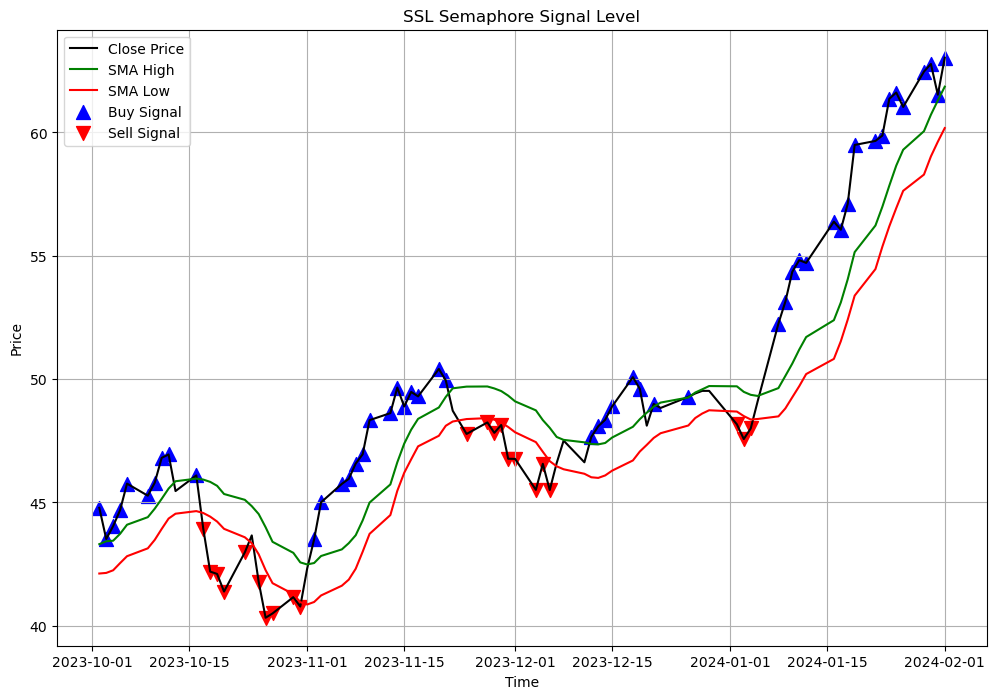

In [5]:
df = calculate_moving_averages(data)

df_cleaned = df.dropna()
df_cleaned

df_cleaned = generate_ssl_signals(df_cleaned)

plot_ssl_signals(df_cleaned, start_date='2023-10-01', end_date='2024-02-01')

Trade Analysis:
total: AutoOrderedDict([('total', 1), ('open', 1)])

Returns Analysis:
rtot: -inf
ravg: -inf
rnorm: -inf
rnorm100: -inf


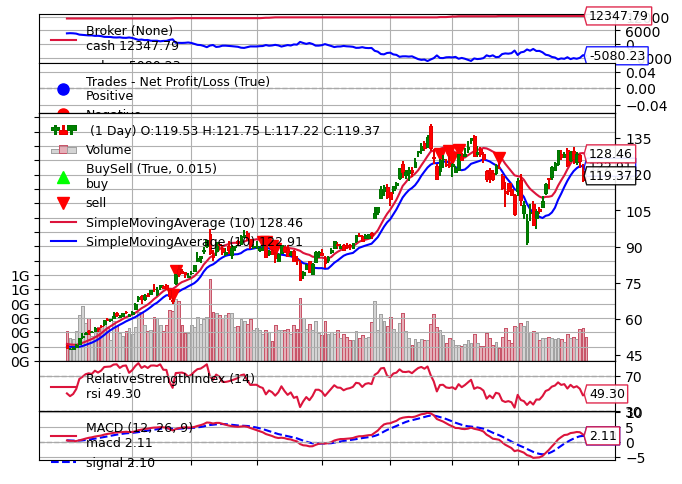

KeyError: 

In [67]:
# Back Testing using Back Trader Object Oriented 
import backtrader as bt
import backtrader.plot as bplot
import backtrader.analyzers as btanalyzers
from datetime import datetime
%matplotlib inline

# Define the SSL Strategy
class SSLStrategy(bt.Strategy):
    def __init__(self):
        # Define the indicators we want to use
        self.sma_high = bt.indicators.SimpleMovingAverage(self.data.high, period=10)
        self.sma_low = bt.indicators.SimpleMovingAverage(self.data.low, period=10)
        self.rsi = bt.indicators.RelativeStrengthIndex(self.data.close, period=14)
        self.macd = bt.indicators.MACD(self.data.close)

    # The next() method is called for every bar (daily, hourly, etc.)
    def next(self):
        # Buy condition: Close price above SMA high, RSI < X, and MACD > Signal
        if self.data.close > self.sma_high and self.rsi < 10 and self.macd.macd > self.macd.signal:
            self.buy()

        # Sell condition: Close price below SMA low, RSI > X, and MACD < Signal
        elif self.data.close < self.sma_low and self.rsi > 50 and self.macd.macd < self.macd.signal:
            self.sell()

# Initialize Backtrader
cerebro = bt.Cerebro()

# Add the SSL Strategy to Backtrader
cerebro.addstrategy(SSLStrategy)

# Convert the pandas DataFrame into Backtrader Data Feed
data_feed = bt.feeds.PandasData(dataname=df_cleaned)

# Add the data feed to Backtrader
cerebro.adddata(data_feed)

# Add analyzers to Backtrader
cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='trade_analyzer')
cerebro.addanalyzer(btanalyzers.Returns, _name='returns')

# Run the backtest
results = cerebro.run()

# Accessing the results of the analyzers
trade_analyzer = results[0].analyzers.trade_analyzer.get_analysis()
returns_analyzer = results[0].analyzers.returns.get_analysis()

# Print the trade analysis
print("Trade Analysis:")
for key, value in trade_analyzer.items():
    print(f"{key}: {value}")

# Print the returns analysis
print("\nReturns Analysis:")
for key, value in returns_analyzer.items():
    print(f"{key}: {value}")



start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 9, 1)

# Generate the plot with Backtrader
cerebro.plot(iplot=False, style='candlestick', volume=True, barup='green', bardown='red',start=start_date, end=end_date)  # This returns a list of figures

# Print trade statistics
print(f"Total Trades: {trade_analyzer.total.closed}")
print(f"Winning Trades: {trade_analyzer.won.total}")
print(f"Losing Trades: {trade_analyzer.lost.total}")
print(f"Total PnL: {trade_analyzer.pnl.net.total}")
print(f"Strike Rate: {trade_analyzer.won.total / trade_analyzer.total.closed * 100:.2f}%")

# Print returns statistics
print(f"Total Return: {returns_analyzer.rnorm100}%")





In [46]:
# Volume Indicator (On-Balance Volume - OBV)
df_cleaned.loc[:, 'obv'] = talib.OBV(df_cleaned['close'], df_cleaned['volume'])

# Momentum Indicators (RSI and MACD)
df_cleaned.loc[:, 'rsi'] = talib.RSI(df_cleaned['close'], timeperiod=21)

# Assign MACD, signal, and histogram
df_cleaned.loc[:, 'macd'], df_cleaned.loc[:, 'macdsignal'], df_cleaned.loc[:, 'macdhist'] = talib.MACD(df_cleaned['close'], fastperiod=12, slowperiod=26, signalperiod=9)

df_cleaned = df_cleaned.dropna()
df_cleaned

open        high         low       close   adj close  \
Date                                                                     
2010-04-22    0.408250    0.418000    0.402500    0.416750    0.382254   
2010-04-23    0.415500    0.416500    0.403750    0.411000    0.376980   
2010-04-26    0.411500    0.420000    0.410750    0.415000    0.380649   
2010-04-27    0.412000    0.416250    0.402000    0.403250    0.369872   
2010-04-28    0.403000    0.409750    0.395750    0.404000    0.370560   
...                ...         ...         ...         ...         ...   
2024-08-30  119.529999  121.750000  117.220001  119.370003  119.370003   
2024-09-03  116.010002  116.209999  107.290001  108.000000  108.000000   
2024-09-04  105.410004  113.269997  104.120003  106.209999  106.209999   
2024-09-05  104.989998  109.650002  104.760002  107.209999  107.209999   
2024-09-06  108.040001  108.150002  100.949997  102.830002  102.830002   

               volume    sma_high     sma_low  buy_signal  sell_signal  \
Date                                                                     
2010-04-22  656932000    0.434800    0.422000           0           -1   
2010-04-23  752916000    0.433825    0.420500           0           -1   
2010-04-26  491092000    0.432400    0.419125           0           -1   
2010-04-27  606704000    0.429725    0.416075           0           -1   
2010-04-28  672164000    0.425375    0.411650           0           -1   
...               ...         ...         ...         ...          ...   
2024-08-30  333751600  128.455001  122.911000           0           -1   
2024-09-03  477155100  127.076001  121.298000           0           -1   
2024-09-04  372470300  125.415000  119.121001           0           -1   
2024-09-05  306850700  123.445000  116.931001           0           -1   
2024-09-06  413638100  121.185000  114.716000           0           -1   

                     obv        rsi      macd  macdsignal  macdhist  buy  sell  
Date                                                                            
2010-04-22  2.713448e+09  45.496065 -0.003586   -0.001165 -0.002420    0    -1  
2010-04-23  1.960532e+09  43.659359 -0.004689   -0.001870 -0.002819    0     0  
2010-04-26  2.451624e+09  45.273143 -0.005181   -0.002532 -0.002649    0    -1  
2010-04-27  1.844920e+09  41.598073 -0.006445   -0.003315 -0.003130    0     0  
2010-04-28  2.517084e+09  41.914091 -0.007301   -0.004112 -0.003189    0     0  
...                  ...        ...       ...         ...       ...  ...   ...  
2024-08-30  1.076249e+11  50.393902  2.114156    2.103284  0.010873    1     0  
2024-09-03  1.071478e+11  43.958329  0.816717    1.845970 -1.029253    0    -1  
2024-09-04  1.067753e+11  43.049547 -0.351895    1.406397 -1.758292    0     0  
2024-09-05  1.070822e+11  43.731912 -1.183691    0.888380 -2.072071    0    -1  
2024-09-06  1.066685e+11  41.447965 -2.171296    0.276444 -2.447741    0     0  

[3619 rows x 17 columns]

In [71]:
# Feature engineering
# I attempt to optimize features below
df_cleaned.loc[:, 'rsi_buy'] = (df_cleaned['rsi'] < 30).astype(int)  # Buy if RSI < 30
df_cleaned.loc[:, 'rsi_sell'] = (df_cleaned['rsi'] > 70).astype(int)  # Sell if RSI > 70

df_cleaned = df_cleaned.drop(columns=['buy_signal', 'sell_signal'])

df_cleaned

KeyError: "['buy_signal', 'sell_signal'] not found in axis"

In [63]:
# Strategy Implementation
# Signals SSL, Volume, and Momentum
# Define rules for buying, selling, and holding
# RSI, MACD

def generate_trading_signals(df):
    
    # Conditions for buying
    df.loc[:, 'buy'] = np.where((df['rsi'] < 10) & (df['macd'] > df['macdsignal']), 1, 0)
    
    # Conditions for selling
    df.loc[:, 'sell'] = np.where((df['rsi'] > 50) & (df['macd'] < df['macdsignal']), -1, 0)
    
    return df

def generate_macd_signals(df):
    # Conditions for buying
    df.loc[:, 'buy'] = np.where((df['macd'] > df['macdsignal']), 1, 0)
    
    # Conditions for selling
    df.loc[:, 'sell'] = np.where((df['macd'] < df['macdsignal']), -1, 0)
    
    return df

def generate_rsi_signals(df):
    # Conditions for buying
    df.loc[:, 'buy'] = np.where((df['rsi'] < 30), 1, 0)
    
    # Conditions for selling
    df.loc[:, 'sell'] = np.where((df['rsi'] > 50), -1, 0)

    return df
        


df_cleaned = generate_trading_signals(df_cleaned)
df_cleaned

open        high         low       close   adj close  \
Date                                                                     
2010-04-22    0.408250    0.418000    0.402500    0.416750    0.382254   
2010-04-23    0.415500    0.416500    0.403750    0.411000    0.376980   
2010-04-26    0.411500    0.420000    0.410750    0.415000    0.380649   
2010-04-27    0.412000    0.416250    0.402000    0.403250    0.369872   
2010-04-28    0.403000    0.409750    0.395750    0.404000    0.370560   
...                ...         ...         ...         ...         ...   
2024-08-30  119.529999  121.750000  117.220001  119.370003  119.370003   
2024-09-03  116.010002  116.209999  107.290001  108.000000  108.000000   
2024-09-04  105.410004  113.269997  104.120003  106.209999  106.209999   
2024-09-05  104.989998  109.650002  104.760002  107.209999  107.209999   
2024-09-06  108.040001  108.150002  100.949997  102.830002  102.830002   

               volume    sma_high     sma_low           obv        rsi  \
Date                                                                     
2010-04-22  656932000    0.434800    0.422000  2.713448e+09  45.496065   
2010-04-23  752916000    0.433825    0.420500  1.960532e+09  43.659359   
2010-04-26  491092000    0.432400    0.419125  2.451624e+09  45.273143   
2010-04-27  606704000    0.429725    0.416075  1.844920e+09  41.598073   
2010-04-28  672164000    0.425375    0.411650  2.517084e+09  41.914091   
...               ...         ...         ...           ...        ...   
2024-08-30  333751600  128.455001  122.911000  1.076249e+11  50.393902   
2024-09-03  477155100  127.076001  121.298000  1.071478e+11  43.958329   
2024-09-04  372470300  125.415000  119.121001  1.067753e+11  43.049547   
2024-09-05  306850700  123.445000  116.931001  1.070822e+11  43.731912   
2024-09-06  413638100  121.185000  114.716000  1.066685e+11  41.447965   

                macd  macdsignal  macdhist  buy  sell  rsi_buy  rsi_sell  
Date                                                                      
2010-04-22 -0.003586   -0.001165 -0.002420    0     0        0         0  
2010-04-23 -0.004689   -0.001870 -0.002819    0     0        0         0  
2010-04-26 -0.005181   -0.002532 -0.002649    0     0        0         0  
2010-04-27 -0.006445   -0.003315 -0.003130    0     0        0         0  
2010-04-28 -0.007301   -0.004112 -0.003189    0     0        0         0  
...              ...         ...       ...  ...   ...      ...       ...  
2024-08-30  2.114156    2.103284  0.010873    0     0        0         0  
2024-09-03  0.816717    1.845970 -1.029253    0     0        0         0  
2024-09-04 -0.351895    1.406397 -1.758292    0     0        0         0  
2024-09-05 -1.183691    0.888380 -2.072071    0     0        0         0  
2024-09-06 -2.171296    0.276444 -2.447741    0     0        0         0  

[3619 rows x 17 columns]

<Figure size 1400x800 with 0 Axes>

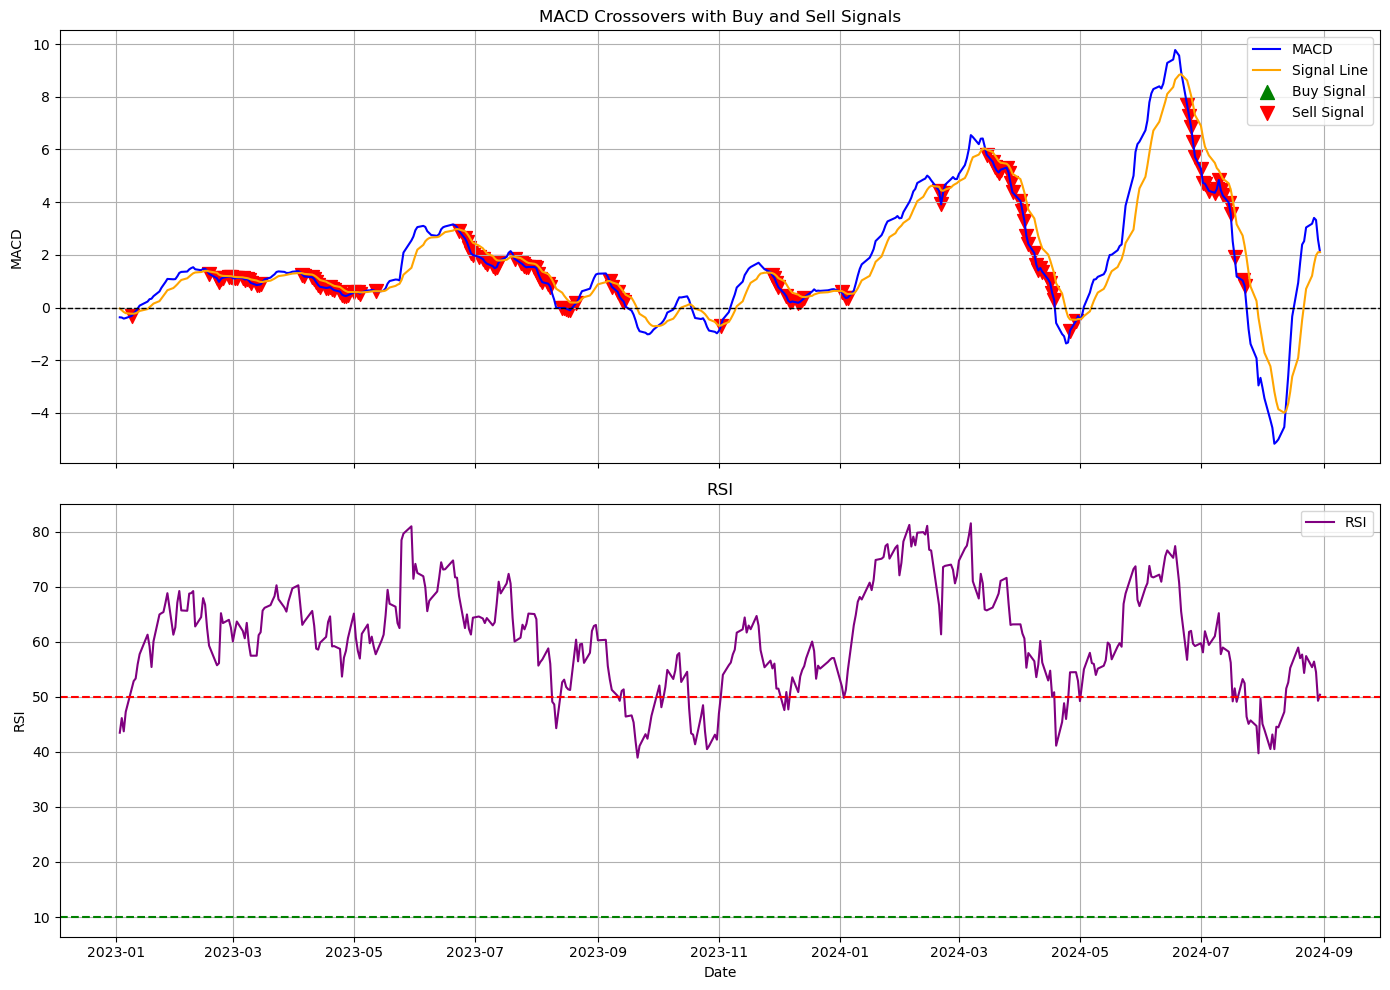

In [70]:
def plot_macd_rsi(df, start_date=None, end_date=None):
    """
    Plot MACD and RSI with buy and sell signals, and allow zooming by date range.

    Parameters:
    df (pd.DataFrame): DataFrame containing MACD, MACD Signal, buy and sell signals, RSI, etc.
    start_date (str or pd.Timestamp): Start date for the plot (optional)
    end_date (str or pd.Timestamp): End date for the plot (optional)
    """

     # Optionally filter the DataFrame for the given date range
    if start_date and end_date:
        df = df[(df.index >= pd.to_datetime(start_date)) & (df.index <= pd.to_datetime(end_date))]

    # Plotting MACD and Signal line with crossovers
    plt.figure(figsize=(14, 8))

    # Create subplots: 2 rows, 1 column
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Plot MACD and Signal line on the first subplot (ax1)
    ax1.plot(df.index, df['macd'], label='MACD', color='blue')
    ax1.plot(df.index, df['macdsignal'], label='Signal Line', color='orange')

    # Highlight buy and sell signals on MACD plot
    ax1.scatter(df.index[df['buy'] == 1], df['macd'][df['buy'] == 1], label='Buy Signal', marker='^', color='green', s=100)
    ax1.scatter(df.index[df['sell'] == -1], df['macd'][df['sell'] == -1], label='Sell Signal', marker='v', color='red', s=100)

    # Add labels, legend, and title for MACD plot
    ax1.set_title('MACD Crossovers with Buy and Sell Signals')
    ax1.axhline(0, color='black', linestyle='--', linewidth=1)  # Horizontal line at MACD 0
    ax1.set_ylabel('MACD')
    ax1.legend()
    ax1.grid(True)

    # Plot RSI on the second subplot (ax2)
    ax2.plot(df.index, df['rsi'], label='RSI', color='purple')
    ax2.axhline(10, color='green', linestyle='--')  # RSI oversold line
    ax2.axhline(50, color='red', linestyle='--')    # RSI overbought line

    # Add labels, legend, and title for RSI plot
    ax2.set_title('RSI')
    ax2.set_ylabel('RSI')
    ax2.set_xlabel('Date')
    ax2.legend()
    ax2.grid(True)

    # Tight layout for better spacing
    plt.tight_layout()

    # Show plot
    plt.show()

plot_macd_rsi(df_cleaned, start_date='2023-01-01', end_date='2024-09-01')

In [28]:
# Export Trade To CSV or Data Frame for futher analysis 

# After running the backtest, you can extract trade data from TradeAnalyzer
trade_list = []

for trade in results[0].analyzers.trade_analyzer.get_analysis().closed:
    trade_data = {
        'Date': trade.dtclose,
        'Entry Price': trade.pricein,
        'Exit Price': trade.priceout,
        'Profit/Loss': trade.pnl,
        'Commission': trade.commission,
        'Size': trade.size
    }
    trade_list.append(trade_data)

# Convert to DataFrame
df_trades = pd.DataFrame(trade_list)
df_trades.head()


KeyError: 